In [6]:
import tensorflow
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array


In [7]:
train_data = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    fill_mode='nearest'
)
test_data=ImageDataGenerator(rescale=1./255)
train_generator=train_data.flow_from_directory(r"C:\Users\Acer\OneDrive\Documents\Datasets\male_female_dataset\train",
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode="categorical"
                                               )
test_generator=test_data.flow_from_directory(r"C:\Users\Acer\OneDrive\Documents\Datasets\male_female_dataset\test",
                                             batch_size=32,
                                             target_size=(224,224),
                                             class_mode="categorical"
                                             )
model = Sequential([
    # Block 1
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Block 4
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # Fully Connected Layers
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(128, activation='relu'),
    Dropout(0.3),

    # ✅ Output layer for 4-class classification
    Dense(2, activation='softmax')
])

# ✅ Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()



Found 11649 images belonging to 2 classes.
Found 708 images belonging to 2 classes.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                   

In [8]:
model.fit(train_generator,epochs=50,validation_data=test_generator)

Epoch 1/50


365/365 [==============================] - 1012s 3s/step - loss: 0.8301 - accuracy: 0.6201 - val_loss: 0.6403 - val_accuracy: 0.6667
Epoch 2/50
365/365 [==============================] - 544s 1s/step - loss: 0.5785 - accuracy: 0.6888 - val_loss: 0.3378 - val_accuracy: 0.8658
Epoch 3/50
365/365 [==============================] - 541s 1s/step - loss: 0.5415 - accuracy: 0.7265 - val_loss: 0.3351 - val_accuracy: 0.8701
Epoch 4/50
365/365 [==============================] - 540s 1s/step - loss: 0.5027 - accuracy: 0.7518 - val_loss: 0.2910 - val_accuracy: 0.8898
Epoch 5/50
365/365 [==============================] - 539s 1s/step - loss: 0.4697 - accuracy: 0.7788 - val_loss: 0.2657 - val_accuracy: 0.8884
Epoch 6/50
365/365 [==============================] - 535s 1s/step - loss: 0.4334 - accuracy: 0.8008 - val_loss: 0.2642 - val_accuracy: 0.8828
Epoch 7/50
365/365 [==============================] - 538s 1s/step - loss: 0.4305 - accuracy: 0.8071 - val_loss: 0.2208 - val_accuracy: 0.9

In [15]:
model.save("Male_Female_Detection_Model.h5",include_optimizer=False)
# model.save("Male_Female_Detection_Model.keras", include_optimizer=False)


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
print(train_generator.class_indices)


{'female': 0, 'male': 1}


In [11]:
from tensorflow.keras.models import load_model

model = load_model("Male_Female_Detection_Model.h5")
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                        

In [12]:
import os

for f in os.listdir():
    if f.endswith(".h5"):
        print(f)


Male_Female_Detection_Model.h5


In [ ]:


# ✅ Load the pre-trained model
model = load_model("Male_Female_Detection_Model.h5")
class_names = ["female", "male"]

# ✅ Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# ✅ Start webcam
cap = cv2.VideoCapture(0)

# FPS tracker
prev_time = time.time()

print("🔵 Starting Gender Detection Stream... (press Ctrl+C to stop)")

try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)

        for (x, y, w, h) in faces:
            roi = frame[y:y+h, x:x+w]
            roi_resized = cv2.resize(roi, (224, 224))
            roi_array = img_to_array(roi_resized) / 255.0
            roi_array = np.expand_dims(roi_array, axis=0)

            pred = model.predict(roi_array, verbose=0)

            # Handle binary or categorical output
            if pred.shape[1] == 2:
                class_id = np.argmax(pred[0])
                label = class_names[class_id]
                confidence = pred[0][class_id] * 100
            else:
                prob = pred[0][0]
                label = class_names[int(prob > 0.5)]
                confidence = prob * 100 if label == "male" else (1 - prob) * 100

            # Draw label and box
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(frame, f"{label} ({confidence:.1f}%)", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        # ✅ Compute FPS
        curr_time = time.time()
        fps = 1 / (curr_time - prev_time + 1e-6)
        prev_time = curr_time
        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)

        # ✅ Show frame inline instead of using cv2.imshow()
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show()

        # Optional: slow down refresh rate slightly for notebooks
        time.sleep(0.05)

except KeyboardInterrupt:
    print("🟡 Stream manually stopped by user.")

finally:
    cap.release()
    print("✅ Camera released successfully.")


🟡 Stream manually stopped by user.
✅ Camera released successfully.


In [14]:
print(train_generator.class_indices)
import numpy as np
unique, counts = np.unique(train_generator.classes, return_counts=True)
print(dict(zip(unique, counts)))


{'female': 0, 'male': 1}
{0: 5841, 1: 5808}


In [ ]:
from collections import Counter
import numpy as np

# Count samples per class
class_counts = Counter(train_generator.classes)
total = sum(class_counts.values())

# Map class indices back to class names
class_names = list(train_generator.class_indices.keys())

# Print distribution
for class_id, count in class_counts.items():
    percentage = (count / total) * 100
    print(f"{class_names[class_id]}: {count} images ({percentage:.2f}%)")


female: 23243 images (49.44%)
male: 23766 images (50.56%)


In [ ]:
print(train_generator.class_indices)


{'female': 0, 'male': 1}


Predicted: male (85.23%)


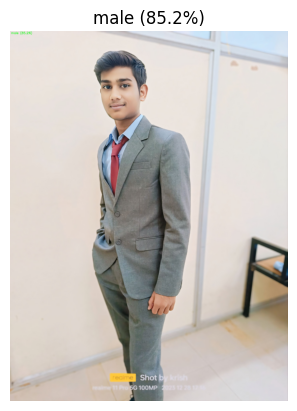

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the model
model = load_model("Male_Female_Detection_Model.h5")

# Make sure this matches your training order
class_names = ['female', 'male']  # double-check this using train_generator.class_indices

# Load your test image
image_path = r"c:\Users\Acer\OneDrive\Pictures\ritesh.jpg"  # <- change path accordingly
image = cv2.imread(image_path)

# Preprocess the image
image_resized = cv2.resize(image, (224, 224))  # match model input size
image_array = img_to_array(image_resized) / 255.0
image_array = np.expand_dims(image_array, axis=0)

# Predict
pred = model.predict(image_array, verbose=0)
class_id = np.argmax(pred[0])
confidence = pred[0][class_id] * 100
label = class_names[class_id]

# Show results
print(f"Predicted: {label} ({confidence:.2f}%)")

# Display the image with prediction
cv2.putText(image, f"{label} ({confidence:.1f}%)", (10, 30),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
import matplotlib.pyplot as plt

# Convert BGR → RGB for correct color display
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"{label} ({confidence:.1f}%)")
plt.axis('off')
plt.show()


In [18]:
import tensorflow as tf
import tf2onnx

model = tf.keras.models.load_model("Male_Female_Detection_Model.h5")

spec = (tf.TensorSpec((1, 224, 224, 3), tf.float32, name="input"),)

output_path = "model.onnx"
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13, output_path=output_path)

print("Conversion complete! Saved as model.onnx")




Conversion complete! Saved as model.onnx
